In [15]:
%matplotlib inline

In [16]:
# Ensure python 3 forward compatibility
# 保证python3前向兼容
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
import theano
# By convention, the tensor submodule is load as T
# 为了方便使用，张量子模型被加载为T
import theano.tensor as T

# 基础
## Symbolic variables符号变量
在Theano中，所有的算法都是符号化定义的。这种方法更类似书写数学表达式。下列的Theano变量都是符号化的；它们都没有明确的值。

In [17]:
# theano.tensor子模块有很多自带的符号化变量类型
# 在这里，我们定义一个标量（scalar）（0-d）变量
# 在参数中给出变量的名字
foo = T.scalar('foo')
# 现在，我们可以定义另一个变量bar，它的值是foo的平方
bar = foo**2
# 这也是一个theano变量
print(type(bar))
print(bar.type)
# 使用theano的pp（pretty print）函数，我们可以看到
# bar是由foo的平方符号化定义的
print(theano.pp(bar))

<class 'theano.tensor.var.TensorVariable'>
TensorType(float64, scalar)
(foo ** TensorConstant{2})


## 函数
为了使用Theano进行实际的计算，你需要定义符号函数，它可以使用实际值调用并返回一共真实值。

In [18]:
# 我们还不能使用foo和bar进行计算
# 我们需要先定义theano函数
# theano.function中的第一个参数定义了函数的输入
# 需要注意bar依赖于foo，所以foo是这个函数的一共输入
# 在给定foo的值后，theano.function会编译代码来计算bar的值
f = theano.function([foo], bar)
print(f(3))

9.0


In [19]:
# 替代性的，在一些情况下你可以使用一个符号变量的估值方法
# 这种方法比定义一个函数更方便
# 这个估值方法接受一个字典，其中键是theano的变量，值是这些变量的值
print(bar.eval({foo: 3}))

9.0


In [20]:
# 我们也可以使用Python函数来构建Theano变量
# 这看起来很麻烦，但是可以让复杂例子的语法更清晰
def square(x):
    return x**2
bar = square(foo)
print(bar.eval({foo: 3}))

9.0


## theano.tensor
Theano也有向量、矩阵、张量的变量类型。theano.tensor子模块有很多函数可以操作这些变量。

In [21]:
A = T.matrix('A')
x = T.vector('x')
b = T.vector('b')
y = T.dot(A, x) + b
# 注意对一个矩阵做平方操作是element-wise
z = T.sum(A**2)
# theano.function可以同时进行很多算
# 你也可以设定参数的默认值
# 我们会在后续涉及到theano.config.floatX
b_default = np.array([0, 0], dtype=theano.config.floatX)
linear_mix = theano.function([A, x, theano.Param(b, default=b_default)], [y, z])
# 为A, x, b设定值
print(linear_mix(np.array([[1, 2, 3],
                           [4, 5, 6]], dtype=theano.config.floatX), #A
                 np.array([1, 2, 3], dtype=theano.config.floatX), #x
                 np.array([4, 5], dtype=theano.config.floatX))) #b
# 使用b的默认值
print(linear_mix(np.array([[1, 2, 3],
                           [4, 5, 6]], dtype=theano.config.floatX), #A
                 np.array([1, 2, 3], dtype=theano.config.floatX))) #x

[array([ 18.,  37.]), array(91.0)]
[array([ 14.,  32.]), array(91.0)]


## Shared variables共享变量
共享变量有一些不同，它们实际上有一个明确的值，并且可以被获取和设置，同时在跨函数使用时共享这些值。它们是很方便的，因为它们在跨函数调用的时候有声明。

In [22]:
shared_var = theano.shared(np.array([[1, 2], [3, 4]], dtype=theano.config.floatX))
# 共享变量的数据类型可以由它的初始化过程推导出
print(shared_var.type())

<TensorType(float64, matrix)>


In [23]:
# 我们可以使用set_value设置一个共享变量的值
shared_var.set_value(np.array([[3, 4], [2, 1]], dtype=theano.config.floatX))
# 并且使用get_value获取值
print(shared_var.get_value())

[[ 3.  4.]
 [ 2.  1.]]


In [24]:
shared_squared = shared_var**2
# theano.function的第一个参数（inputs）告诉Theano编译函数的参数应该是怎么样的
# 由于shared_var是共享的，它已经有了值，所以它没有必要作为一个函数的输入
# 因此，当使用shared_squared时，Theano隐式地将shared_var作为一个函数的输入
# 我们不需要在theano.function的输入变量中包含它
function_1 = theano.function([], shared_squared)
print(function_1())

[[  9.  16.]
 [  4.   1.]]


## updates 更新
共享变量的值可以通过使用theano.function的升级参量来更新

In [25]:
# 我们也可以通过一个函数更新共享变量的声明
substract = T.matrix('substract')
# 更新需要使用一共字典，其中的键为共享变量，值为共享变量的新值
# 这里，更新会设置shared_var = shared_var - substract
function_2 = theano.function([substract], shared_var, updates={shared_var: shared_var - substract})
print("shared_var before substracting [[1, 1], [1, 1]] using function_2:")
print(shared_var.get_value())
# 从shared_var中减去[[1, 1], [1, 1]]
function_2(np.array([[1, 1], [1, 1]], dtype=theano.config.floatX))
print("shared_var after calling function_2:")
print(shared_var.get_value())
# 注意这种方式也改变function_1的输出，应为shared_var是共享的
print("New output of function_1() (shared_var*2):")
print(function_1())

shared_var before substracting [[1, 1], [1, 1]] using function_2:
[[ 3.  4.]
 [ 2.  1.]]
shared_var after calling function_2:
[[ 2.  3.]
 [ 1.  0.]]
New output of function_1() (shared_var*2):
[[ 4.  9.]
 [ 1.  0.]]


## Gradients 梯度
使用Theano的一个很大的好处是它可以计算梯度。这可以让你符号化地定义一个函数并且快速计算它的（数学上的）导数，而不用真正去求导。

In [26]:
# 回想bar = foo**2
# 我们可以计算bar的梯度，而不用考虑foo：
bar_grad = T.grad(bar, foo)
# 我们期望的是bar_grad = 2**foo
bar_grad.eval({foo: 10})

array(20.0)

In [27]:
# 回想 y = Ax + b
# 我们可以用如下方法计算雅可比矩阵：
y_J = theano.gradient.jacobian(y, x)
linear_mix_J = theano.function([A, x, b], y_J)
# 因为这是一个线性混合，我们期望的输出永远是A
print(linear_mix_J(np.array([[9, 8, 7], [4, 5, 6]], dtype=theano.config.floatX), #A
                   np.array([1, 2, 3], dtype=theano.config.floatX), #x
                   np.array([4, 5], dtype=theano.config.floatX))) #b
# 我们也可以使用theano.gradient.hessian来计算黑塞矩阵Hessian

[[ 9.  8.  7.]
 [ 4.  5.  6.]]


## Debugging 调试
在Theano上调试会有一些困难，因为代码实际运行的时候，和你写的代码已经相去甚远。一种在实际编译函数之前，简便检查你的Theano表达式的方法就是使用测试变量。

In [28]:
# 让我们创建另一个矩阵“B”
B = T.matrix('B')
# 和一个符号变量表示A和B的点乘
# 在这种情况，Theano并不知道A和B的形状shapes，所以没有办法知道A点乘B是否是有效的。
C = T.dot(A, B)
# 现在让我们使用它
C.eval({A: np.zeros((3, 4), dtype=theano.config.floatX),
        B: np.zeros((5, 6), dtype=theano.config.floatX)})

ValueError: Shape mismatch: x has 4 cols (and 3 rows) but y has 5 rows (and 6 cols)
Apply node that caused the error: Dot22(A, B)
Inputs types: [TensorType(float64, matrix), TensorType(float64, matrix)]
Inputs shapes: [(3, 4), (5, 6)]
Inputs strides: [(32, 8), (48, 8)]
Inputs values: ['not shown', 'not shown']

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.
HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

上面的错误信息有一些不透明（并且如果我们没有给定Theano变量A和B的名字的时候会更难阅读）。当Theano表达式很复杂的时候，会变得尤为难懂。它也不会告诉你在Python代码中出现错误的行号，因为实际运行的并不是你的Python代码，而是编译后的Theano代码！还好，“test values”可以让我们处理这个问题。但是，并不是所有Theano方法都允许测试值（test values)（例如 scan方法）

In [29]:
# 这告诉Theano我们将要使用test values，并且当出现错误时发出警告。
# 设置‘warn’表示“当我没有提供一个测试值时警告我”
theano.config.compute_test_value = 'warn'
# 设置参数tag.test_value，赋予变量它的测试值
A.tag.test_value = np.random.random((3, 4)).astype(theano.config.floatX)
B.tag.test_value = np.random.random((5, 6)).astype(theano.config.floatX)
# 现在，当我们计算C的时候会得到错误信息，指出我们需要修正的行
C = T.dot(A, B)

ValueError: shapes (3,4) and (5,6) not aligned: 4 (dim 1) != 5 (dim 0)

In [30]:
# 我们在接下来的教程中将不使用测试值
theano.config.compute_test_value = 'off'

使用调试的另一个有用的地方是，当一个无效的计算被执行的时候，例如结果是nan。默认情况下，Theano会静默地允许这些nan值被使用和计算，但是这种默认操作会导致你的Theano计算产生灾难性的后果。如果时间允许，我们可以选择在DebugMode使用Theano编译函数，由于一个无效计算会产生一个错误。

In [31]:
# 一个简单的除法函数
num = T.scalar('num')
den = T.scalar('den')
divide = theano.function([num, den], num/den)
print(divide(10, 2))
# 这会导致一个NaN
print(divide(0, 0))

5.0
nan


In [32]:
# 要在编译模式下编译一个方程，只需要设置mode='DebugMode'
divide = theano.function([num, den], num/den, mode='DebugMode')
# NaNs现在会产生一个错误
print(divide(0, 0))

InvalidValueError: InvalidValueError
        type(variable) = TensorType(float64, scalar)
        variable       = Elemwise{true_div,no_inplace}.0
        type(value)    = <type 'numpy.ndarray'>
        dtype(value)   = float64
        shape(value)   = ()
        value          = nan
        min(value)     = nan
        max(value)     = nan
        isfinite       = False
        client_node    = None
        hint           = perform output
        specific_hint  = non-finite elements not allowed
        context        = ...
  Elemwise{true_div,no_inplace} [@A] ''   
   |num [@B]
   |den [@C]

        

## 使用CPU和GPU
官方手册：<http://deeplearning.net/software/theano/library/config.htm>
使用floatX，在稍后程序中再指定64位或32位

* CPU

THEANO_FLAGS=device=cpu,floatX=float64 python your_script.py
* GPU

THEANO_FLAGS=device=gpu,floatX=float32 python your_script.py

In [33]:
# 查看Theano目前使用的参数：
print(theano.config.device)
print(theano.config.floatX)

cpu
float64


In [34]:
# 在runtime的时候获取/设置
old_floatX = theano.config.floatX
theano.config.floatX = 'float32'

In [35]:
# 需要注意，你实际中使用的是floatX！
# 例如，下列操作会导致var变成float64，而不管floatX，由于numpy的默认设置
var = theano.shared(np.array([1.3, 2.4]))
print(var.type()) #!!!
# 所以，只要你使用了一个numpy array，就要确认设置它的dtype为theano.config.floatX
var = theano.shared(np.array([1.3, 2.4], dtype=theano.config.floatX))
print(var.type())
# 恢复到旧的值
theano.config.floatX = old_floatX

<TensorType(float64, vector)>
<TensorType(float32, vector)>


In [36]:
theano.config.floatX = 'float64'

In [37]:
print(theano.config.device)
print(theano.config.floatX)

cpu
float64


# 实例：MLP
多层感知机的tutorial：<http://en.wikipedia.org/wiki/Multilayer_perceptron>
我们将按照一般约定，将数据点设置为列向量

## layer class 层类
我们将把我们的多层感知机定义为一系列的“层”（layers），每一层继承地放置在输入层之后，产生网络的输出。每一层被定义为一个类，其中保存了一个权重矩阵，一个偏置向量和一个计算层输出的函数。

Note that if we weren't using Theano, we might expect the output method to take in a vector and return the layer's activation in response to this input. However, with Theano, the output function is instead meant to be used to create (using theano.function) a function which can take in a vector and return the layer's activation. So, if you were to pass, say, a np.ndarray to the Layer class's output function, you'd get an error. Instead, we'll construct a function for actually computing the Layer's activation outside of the class itself.

In [49]:
class Layer(object):
    def __init__(self, W_init, b_init, activation):
        '''
        一共神经网络的一层，计算 s(Wx + b)，其中s是一个非线性函数，x是输入向量
        A layer of a neural network, computes s(Wx + b) where s is a nonlinearity and x is the input vector.

        :parameters:
            - W_init : np.ndarray, shape=(n_output, n_input)
                Values to initialize the weight matrix to.
            - b_init : np.ndarray, shape=(n_output,)
                Values to initialize the bias vector
            - activation : theano.tensor.elemwise.Elemwise
                Activation function for layer output
        '''
        # 在以W的初始化为基础时，召回输入和输出的维度
        n_output, n_input = W_init.shape
        # 确保b的size是n_output
        assert b_init.shape == (n_output,)
        # 所有的参数都要是共享变量
        # 在这个类中，它们被用来计算层的输出，但是在其他优化网络参数的时候被更新
        # 注意我们明确要求，W_init的dtype是theano.config.floatX
        self.W = theano.shared(value=W_init.astype(theano.config.floatX),
                               # 参数的名字仅仅是为了打印方便
                               name = 'W',
                               # 设置 borrow=True允许Theano为了这个项目使用用户的内存
                               # 这可以让代码运行快一点，避免一些深度拷贝
                               # 更多细节可以参看
                               # http://deeplearning.net/software/theano/tutorial/aliasing.html
                               borrow = True)
        # 我们可以使用numpy的reshape方法，强制偏置向量b变成一个列向量。
        # 当b是一个列向量的时候，我们可以传递一个matrix-shaped的输入给layer
        # 并且得到一个matrix-shaped的输出。由于broadcasting
        self.b = theano.shared(value=b_init.reshape(n_output, 1).astype(theano.config.floatX),
                               name='b',
                               borrow=True,
                               # 和numpy类似，Theano也允许broadcasting
                               # 但是，你需要明确指定哪一个轴去做传播
                               # 通过设定broadcastable=(True, False), 我们可以指定b可以沿着它的第二个维度
                               # 被传播（copied），以被添加给另一个变量。
                               # 详情参阅：http://deeplearning.net/software/theano/library/tensor/basic.html
                               broadcastable=(False, True))
        self.activation = activation
        # 我们会通过列表中的参数，计算网络代价的梯度值
        self.params = [self.W, self.b]
        
    def output(self, x):
        '''
        Compute this layer's output given an input
        
        :parameters:
            - x : theano.tensor.var.TensorVariable
                Theano symbolic variable for layer input

        :returns:
            - output : theano.tensor.var.TensorVariable
                Mixed, biased, and activated x
        '''
        # 计算线性混合linear mix
        lin_output = T.dot(self.W, x) + self.b
        # 如果没有激活函数，输出就只是线性混合
        # 否则，运用激活函数
        return (lin_output if self.activation is None else self.activation(lin_output))

## MLP class 多层感知机类
我们的MLP中很多函数功能都在Layer类中包含了，MLP类本质上只包含了一个Layer列表和它们参数的容器。output函数仅仅是递归地计算每一层的输出。最终，squared_error返回网络给定某个输入后的输出值，和期望（ground truth）输出之间的欧氏距离平方。这个函数是为了被用来在给定一些训练参数时，设置最小化代价。以上这些方法，包括output和squared_error函数，都不是被用来进行真正的值计算的；而是被用作创建一些可以用来计算值的函数。

In [50]:
class MLP(object):
    def __init__(self, W_init, b_init, activations):
        '''
        Multi-layer perceptron class, computes the composition of a sequence of Layers

        :parameters:
            - W_init : list of np.ndarray, len=N
                Values to initialize the weight matrix in each layer to.
                The layer sizes will be inferred from the shape of each matrix in W_init
            - b_init : list of np.ndarray, len=N
                Values to initialize the bias vector in each layer to
            - activations : list of theano.tensor.elemwise.Elemwise, len=N
                Activation function for layer output for each layer
        '''
        # 确保输入列表都有相同的长度
        assert len(W_init) == len(b_init) == len(activations)
        
        # 初始化layer列表
        self.layers = []
        # 构造layers
        for W, b, activation in zip(W_init, b_init, activations):
            self.layers.append(Layer(W, b, activation))
        # 合并所有层的参数
        self.params = []
        for layer in self.layers:
            self.params += layer.params
    
    def output(self, x):
        '''
        Compute the MLP's output given an input
        计算多层感知机的输出
        
        :parameters:
            - x : theano.tensor.var.TensorVariable
                Theano symbolic variable for network input

        :returns:
            - output : theano.tensor.var.TensorVariable
                x passed through the MLP
        '''
        # 递归计算输出
        for layer in self.layers:
            x = layer.output(x)
        return x
    
    def squared_error(self, x, y):
        '''
        Compute the squared euclidean error of the network output against the "true" output y
        计算网络输出值和“真实”输出值y之间的欧式距离误差
        
        :parameters:
            - x : theano.tensor.var.TensorVariable
                Theano symbolic variable for network input
            - y : theano.tensor.var.TensorVariable
                Theano symbolic variable for desired network output

        :returns:
            - error : theano.tensor.var.TensorVariable
                The squared Euclidian distance between the network output and y
        '''
        return T.sum((self.output(x) - y)**2)

## Gradient descent 梯度下降
为了训练网络，我们使用梯度下降的放在，在训练集熵最小化损失（网络输出值和ground-truth之间的欧氏距离的平方）。当在一个神经网络上做梯度下降时，通常使用momentum动量，这是一个在参数更新时的leaky integrator。当进行参数更新时，它是现有梯度更新和之前计算的梯度更新的线性混合。这可以使网络更快收敛到一个好的结果，并且避免被困在局部最优解。使用传统的梯度下降法，我们保证每一次迭代都降低损失。当我们使用momentum动量时，我们就不能保证每次都降低损失了，但是这只是一个极小的代价。

在Theano中，我们将之前更新的参数存储为一个共享变量，所以在进行不同迭代时它的值会被保存下来。接着在更新梯度时，我们不仅更新参数，还更新之前参数的共享变量。

In [51]:
def gradient_updates_momentum(cost, params, learning_rate, momentum):
    '''
    Compute updates for gradient descent with momentum
    
    :parameters:
        - cost : theano.tensor.var.TensorVariable
            Theano cost function to minimize
        - params : list of theano.tensor.var.TensorVariable
            Parameters to compute gradient against
        - learning_rate : float
            Gradient descent learning rate
        - momentum : float
            Momentum parameter, should be at least 0 (standard gradient descent) and less than 1
   
    :returns:
        updates : list
            List of updates, one for each parameter
    '''
    # 确保momentum是一个合理值
    assert momentum < 1 and momentum >= 0
    # 为每个参数设置更新步骤的列表
    updates = []
    # 只在损失函数上做梯度下降
    for param in params:
        # 对于每个参数，我们创建一个param_update的共享变量
        # 这个变量会保存参数更新的每一步状态
        # 我们将它初始化为0
        param_update = theano.shared(param.get_value()*0., broadcastable=param.broadcastable)
        # 每个参数都在梯度方向上更新一步
        # 尽管如此，我们也根据给定的momentum值来混合之前的步骤
        updates.append((param, param - learning_rate*param_update))
        # 注意到我们没必要推导反向传播来计算更新量，只要使用T.grad就行
        updates.append((param_update, momentum*param_update + (1. - momentum)*T.grad(cost, param)))
    return updates

## Toy example 示例
我们会训练我们的神经网络，在二维空间中分类两个符合高斯分布的簇

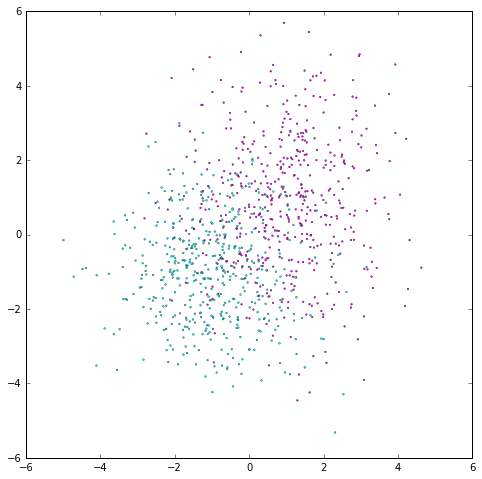

In [52]:
# 训练数据 - 两个随机生成的符合高斯分布的二维空间点云
np.random.seed(0)
# 点的数量
N = 1000
# 每个簇的标签
y = np.random.random_integers(0, 1, N)
# 每个簇的中心点
means = np.array([[-1, 1], [-1, 1]])
# 每个簇在X和Y方向上的协方差
covariances = np.random.random_sample((2, 2)) + 1
# 每个点的维度
X = np.vstack([np.random.randn(N)*covariances[0, y] + means[0, y],
               np.random.randn(N)*covariances[1, y] + means[1, y]]).astype(theano.config.floatX)
# 转换目标为floatX
y = y.astype(theano.config.floatX)
# 描绘图像
plt.figure(figsize=(8, 8))
plt.scatter(X[0, :], X[1, :], c=y, lw=.3, s=3, cmap=plt.cm.cool)
plt.axis([-6, 6, -6, 6])
plt.show()

In [53]:
# 首先，设置层layer的规模和数量
# 输入层的规模是训练数据的维度（2）
# 输出规模是1-d， class 标签是0或1
# 最后，设置隐层规模为输入规模的两倍
# 如果我们想要更多层，只需要在这个列表中添加另一个层规模size
layer_sizes = [X.shape[0], X.shape[0]*2, 1]
# 设置参数的初始值
W_init = []
b_init = []
activations = []
for n_input, n_output in zip(layer_sizes[:-1], layer_sizes[1:]):
    # 设置正确的初始化对于大规模数据是很重要的
    # 尽管如此，在这里我们只需要使用如下初始化过程：
    # Normally distribute initial weights
    W_init.append(np.random.randn(n_output, n_input))
    # 将偏置初始化为1
    b_init.append(np.ones(n_output))
    # 我们使用sigmoid函数作为所有层的激励函数
    # 需要注意，在使用平方距离的时候，这并没有太大的意义
    # 因为sigmoid函数被限定在[0, 1]
    activations.append(T.nnet.sigmoid)
# 创建一共MLP类的实例
mlp = MLP(W_init, b_init, activations)

# 为MLP的输入创建Theano变量
mlp_input = T.matrix('mlp_input')
# 和期望的输出
mlp_target = T.vector('mlp_target')
# 学习率和momentum的超参数值
# 再次强调，这些值对于大规模数据有着很大的影响
# 同时影响网络是否快速收敛到一个很好的局部最优解
learn_rate = 0.01
momentum = 0.9
# 创建一个函数来计算给定输入时网络的损失函数
cost = mlp.squared_error(mlp_input, mlp_target)
# 创建一个theano函数来训练网络
train = theano.function([mlp_input, mlp_target], cost,
                        updates=gradient_updates_momentum(cost, mlp.params, learn_rate, momentum))
# 创建一个theano函数来计算MLP的输出
mlp_output = theano.function([mlp_input], mlp.output(mlp_input))

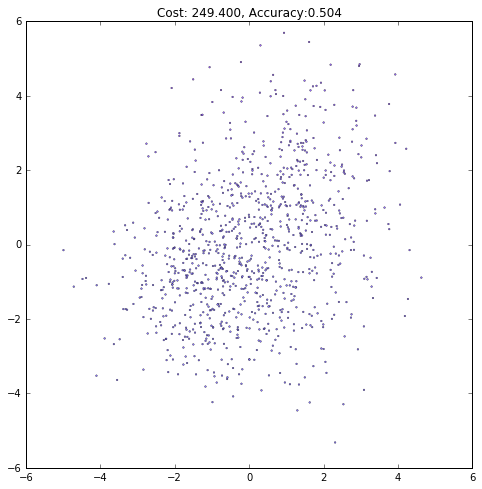

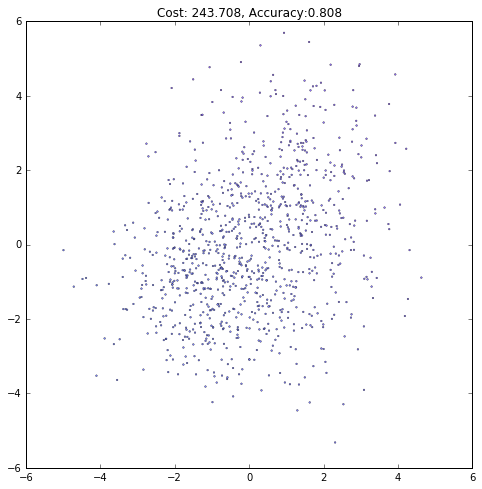

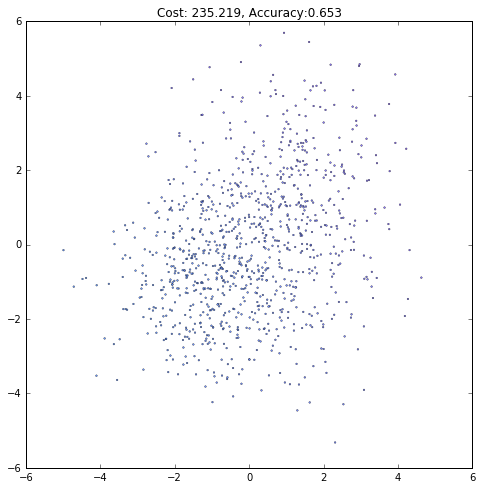

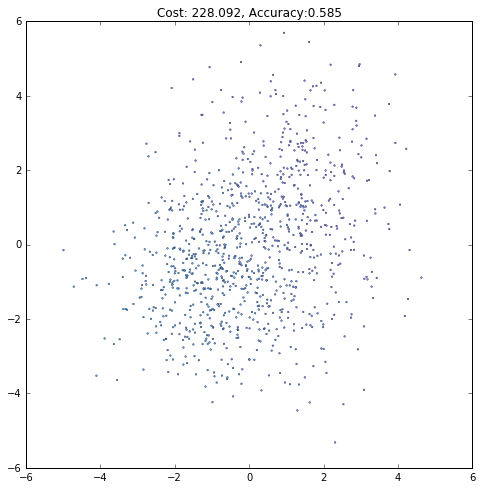

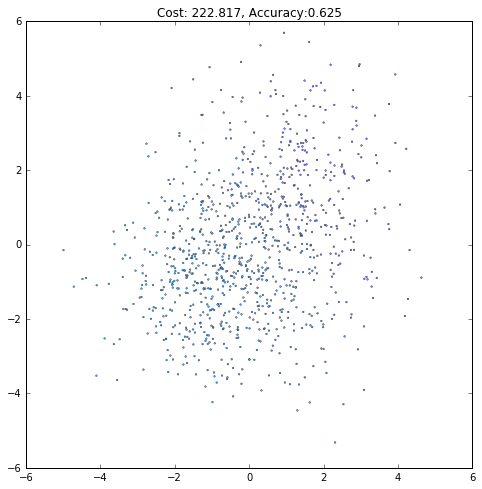

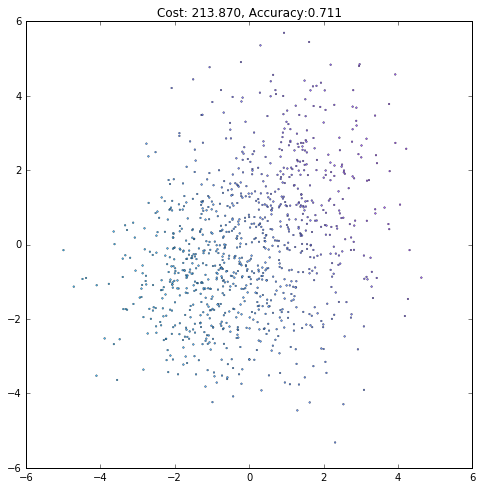

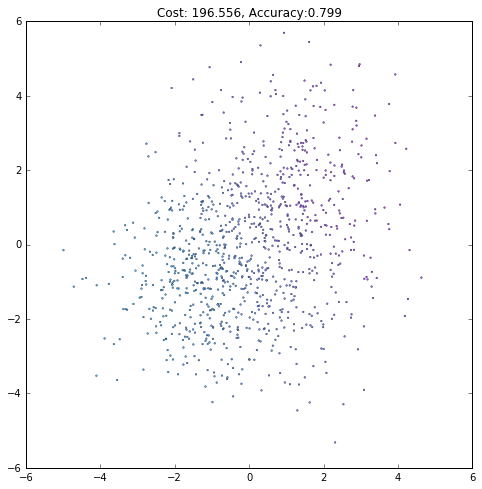

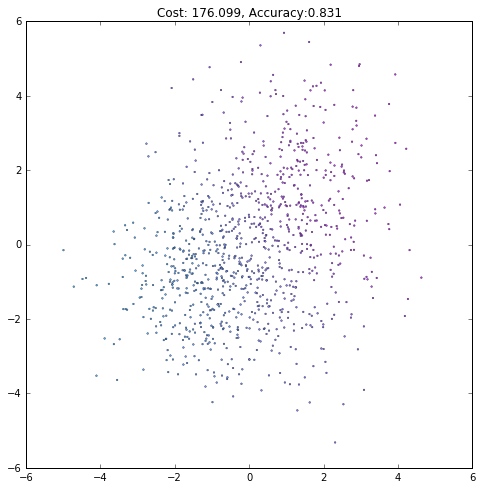

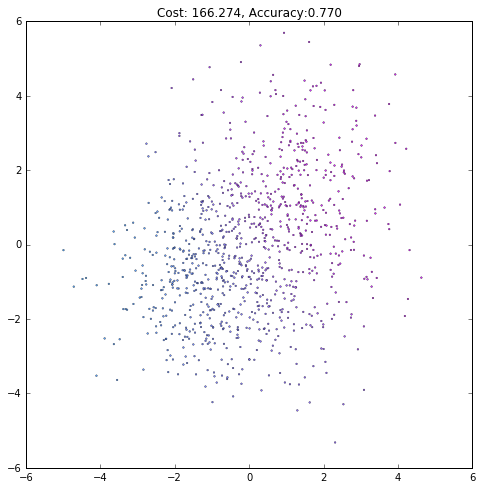

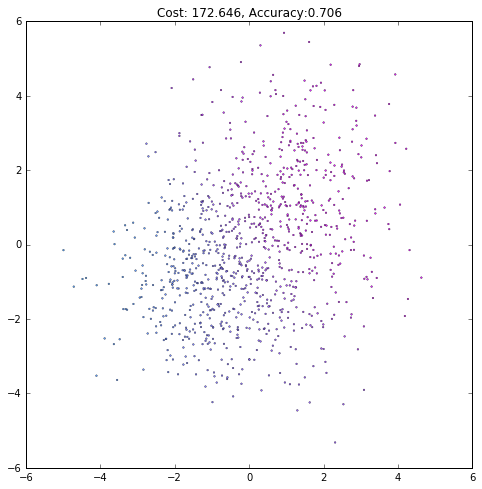

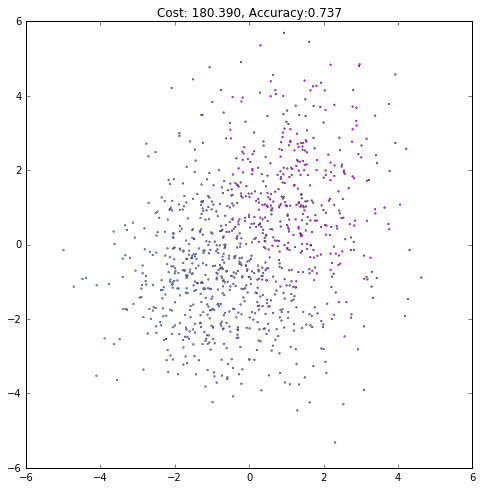

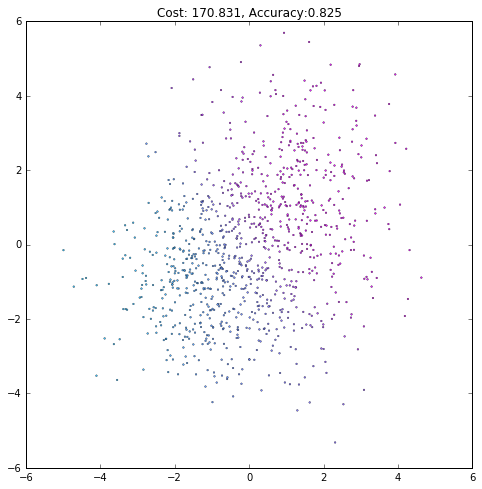

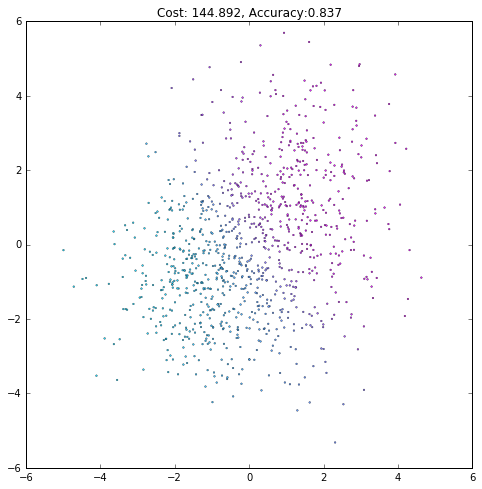

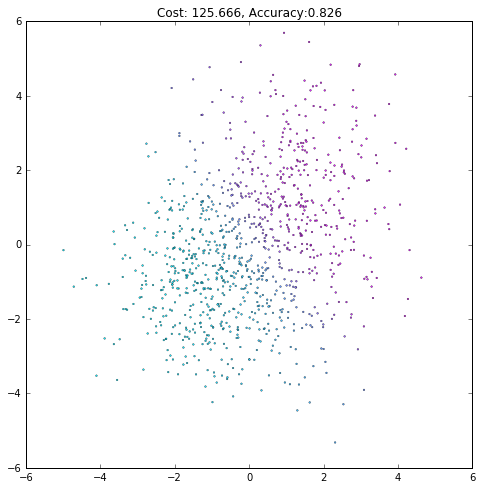

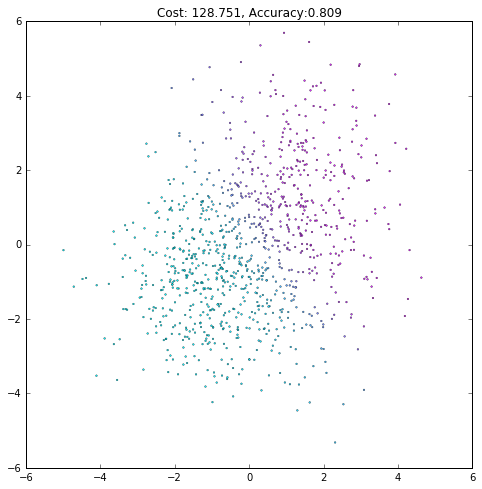

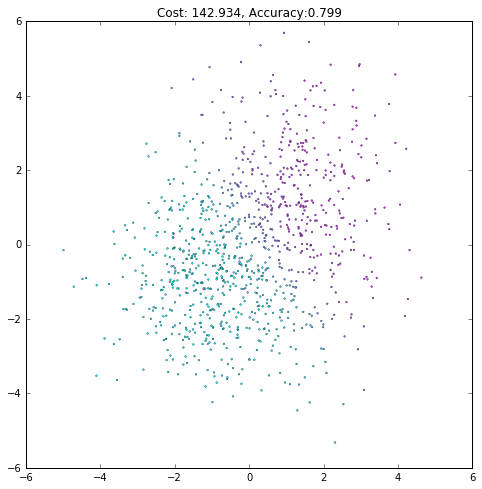

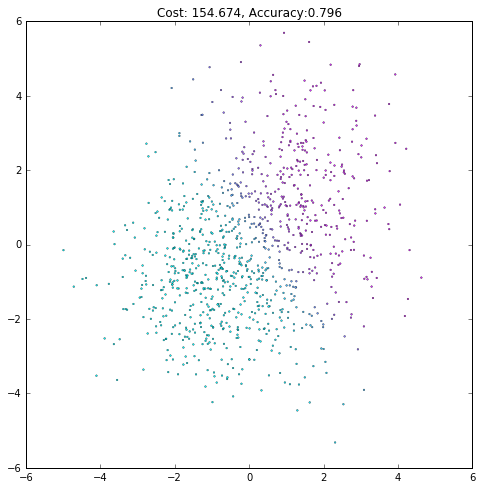

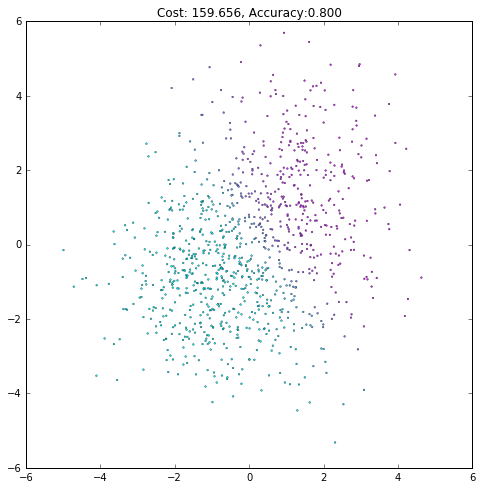

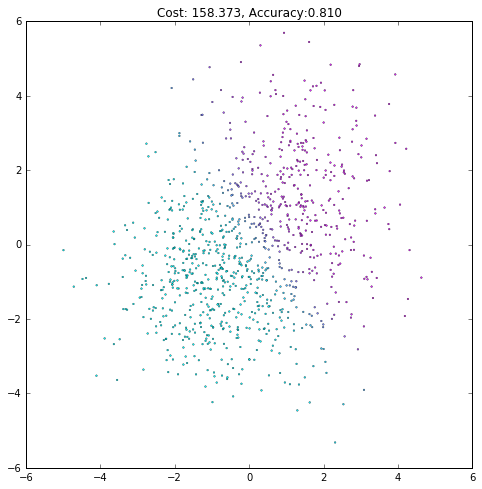

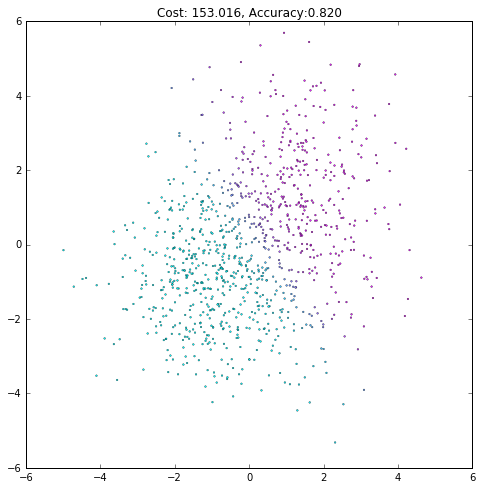

In [55]:
# 跟踪记录训练迭代的次数
iteration = 0
# 我们只会对网络进行20次训练迭代
# 一个更一般的技巧是使用一个hold-out验证集
# 当验证误差开始增加时，网络就过拟合了
# 所以我们停止训练网络，这被称为“early stopping”，这里我们不会涉及
max_iteration = 20
while iteration < max_iteration:
    # 用整个训练集来训练网络
    # 当数据集很大时，一般使用随机梯度下降或者mini-batch梯度下降法
    # 这时每次迭代只有一小部分或者一个点的数据被用来训练
    # 这也有助于防止网络陷入局部最优点
    current_cost = train(X, y)
    # 为训练集中的所有点获取现有网络的输出
    current_output = mlp_output(X)
    # 我们可以通过限制输出阈值计算精确度
    # 并计算正确分类的点所占的百分比
    accuracy = np.mean((current_output > .5) == y)
    # 绘制迭代后网络输出的图像
    plt.figure(figsize=(8, 8))
    plt.scatter(X[0, :], X[1, :], c=current_output,
                lw=.3, s=3, cmap=plt.cm.cool, vmin=0, vmax=1)
    plt.axis([-6, 6, -6, 6])
    plt.title('Cost: {:.3f}, Accuracy:{:.3f}'.format(float(current_cost), accuracy))
    plt.show()
    iteration += 1